# Difftest Results

Connect to results database:

In [1]:
import db
from db import *

hostname = "cc1"
db.init(hostname)

'mysql://cc1:3306/project_b'

## Overview

In [2]:
import pandas as pd

session = db.make_session()

TABLE_NAMES = ["CLSmith", "CLSmith w. cldrive", "GitHub", "CLgen"]
TABLES = [CLSmithResult, cldriveCLSmithResult, GitHubResult, CLgenResult]

data = [
    ("#. Programs", [session.query(t.program_id).group_by(t.program_id).count() for t in TABLES]),
    ("#. Testbeds", [session.query(t.testbed_id).group_by(t.testbed_id).count() for t in TABLES]),
    ("#. Params", [session.query(t.params_id).group_by(t.params_id).count() for t in TABLES]),
    ("#. Results", [session.query(t).count() for t in TABLES])
]
i, d = zip(*data)
overview = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
overview

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
#. Programs,10001,10001,9238,1000
#. Testbeds,6,4,4,4
#. Params,4,4,4,4
#. Results,166950,146134,88398,16000


# Experimental Setup

### TestBeds

A testbed is a combination of host platform and OpenCL device.

In [3]:
import sqlalchemy as sql

DEVICES = {  # shorthand device names
    "GeForce GTX 1080": "NVIDIA GTX 1080",
    "Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620",
    "Olcgrind Simulator": "Oclgrind",
    "pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz": "Intel E5-2620 (pocl)",
    "Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz": "Intel i5-4570",
    'Intel(R) HD Graphics Haswell GT2 Desktop': 'Intel HD Haswell GT2',
}

DRIVERS = {
    "Oclgrind 16.10": "16.10",
}

PLATFORMS = {
    "Portable Computing Language": "POCL",
}

q = session.query(Testbed).order_by(sql.func.field(Testbed.devtype, 'GPU', 'CPU', 'Emulator'))

data = []
for testbed in q:
    data.append(
        (testbed.id, [
            testbed.host, DEVICES.get(testbed.device, testbed.device),
            DRIVERS.get(testbed.driver, testbed.driver), testbed.opencl, testbed.devtype] +
         [session.query(t.testbed).filter(t.testbed == testbed).count() for t in TABLES]))
i, d = zip(*data)
testbeds = pd.DataFrame(list(d), index=i, columns=["Operating System", "Device", "Driver", "OpenCL", "Device type"] + [f"#. {t}" for t in TABLE_NAMES])
testbeds

,Operating System,Device,Driver,OpenCL,Device type,#. CLSmith,#. CLSmith w. cldrive,#. GitHub,#. CLgen
12,Ubuntu 16.04 64bit,Intel E5-2620 (pocl),0.14,2.0,3,186900,0,0,0
3,Ubuntu 16.04 64bit,NVIDIA GTX 1080,375.39,1.2,GPU,240024,240024,284682,24000
13,Ubuntu 16.04 64bit,Intel HD Haswell GT2,1.3,1.2,GPU,138,0,0,0
9,Ubuntu 16.04 64bit,Intel E5-2620,1.2.0.25,2.0,CPU,240024,240024,221712,24000
10,Ubuntu 16.04 64bit,Intel i5-4570,1.2.0.25,1.2,CPU,240024,240024,22698,24000
11,Ubuntu 16.04 64bit,Oclgrind Simulator,16.10,1.2,Emulator,94590,156732,1296,24000


In [4]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
import os
data = []
for testbed in session.query(Testbed):
    data.append([
        PLATFORMS.get(testbed.platform, testbed.platform), testbed.device, DRIVERS.get(testbed.driver, testbed.driver),
        testbed.opencl, testbed.host, testbed.devtype])
table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
    "Platform", "Device", "Driver", "OpenCL", "Operating system", "Device type"])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/platforms.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/platforms.tex" && git push
table

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Platform,Device,Driver,OpenCL,Operating system,Device type
1,NVIDIA CUDA,GeForce GTX 1080,375.39,1.2,Ubuntu 16.04 64bit,GPU
2,Intel(R) OpenCL,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,1.2.0.25,2.0,Ubuntu 16.04 64bit,CPU
3,Intel(R) OpenCL,Intel(R) Core(TM) i5-4570 CPU @ 3.20GHz,1.2.0.25,1.2,Ubuntu 16.04 64bit,CPU
4,Oclgrind,Oclgrind Simulator,16.10,1.2,Ubuntu 16.04 64bit,Emulator
5,POCL,pthread-Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,0.14,2.0,Ubuntu 16.04 64bit,3
6,Intel Gen OCL Driver,Intel(R) HD Graphics Haswell GT2 Desktop,1.3,1.2,Ubuntu 16.04 64bit,GPU


## Runtime Parameters

### cl_launcher

In [5]:
q = session.query(cl_launcherParams).order_by(
        cl_launcherParams.gsize_x, cl_launcherParams.gsize_y, cl_launcherParams.gsize_z,
        cl_launcherParams.lsize_x, cl_launcherParams.lsize_y, cl_launcherParams.lsize_z,
        cl_launcherParams.optimizations)

data = []
for param in q:
    nresult_param = session.query(CLSmithResult).filter(CLSmithResult.params == param).count()
    data.append((
        param.id, [param.gsize, param.lsize, param.optimizations_on_off, nresult_param]))
i, d = zip(*data)

cl_launcher_params = pd.DataFrame(list(d), index=i, columns=[
    "Global size", "Local size", "Optimizations", "#. CLSmith"])
cl_launcher_params

,Global size,Local size,Optimizations,#. CLSmith
4,"(1, 1, 1)","(1, 1, 1)",off,45752
3,"(1, 1, 1)","(1, 1, 1)",on,50028
2,"(128, 16, 1)","(32, 1, 1)",off,31150
1,"(128, 16, 1)","(32, 1, 1)",on,40020


### cldrive

In [6]:
CLDRIVE_TABLE_NAMES = ["CLSmith w. cldrive", "GitHub", "CLgen"]
CLDRIVE_TABLES = [cldriveCLSmithResult, GitHubResult, CLgenResult]

q = session.query(cldriveParams).order_by(
        cldriveParams.size,
        cldriveParams.gsize_x, cldriveParams.gsize_y, cldriveParams.gsize_z,
        cldriveParams.lsize_x, cldriveParams.lsize_y, cldriveParams.lsize_z,
        cldriveParams.generator, cldriveParams.scalar_val, cldriveParams.optimizations)

data = []
for param in q:
    data.append((
        param.id,
        [param.size, param.generator, param.scalar_val, param.gsize,
         param.lsize, param.optimizations_on_off] + [
            session.query(t).filter(t.params == param).count()
            for t in CLDRIVE_TABLES
        ]))
i, d = zip(*data)

cldrive_params = pd.DataFrame(list(d), index=i, columns=[
    "Size", "Generator", "Scalar Val", "Global size", "Local size",
    "Optimizations"] + [f"#. {t}" for t in CLDRIVE_TABLE_NAMES])
cldrive_params

,Size,Generator,Scalar Val,Global size,Local size,Optimizations,#. CLSmith w. cldrive,#. GitHub,#. CLgen
11,256,arange,None,"(1, 1, 1)","(1, 1, 1)",off,40004,18530,4000
10,256,arange,None,"(1, 1, 1)","(1, 1, 1)",on,40004,22313,4000
12,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",off,30003,26592,4000
9,4096,arange,None,"(128, 16, 1)","(32, 1, 1)",on,36123,20963,4000


In [7]:
# push LaTex to Overleaf
!cd ~/docs/paper-project_b/ && git pull --rebase
data = []
for param in q:
    data.append([param.size, param.gsize, param.lsize, param.optimizations_on_off])
table = pd.DataFrame(data, index=range(1, len(data)+1), columns=[
    "Dataset Size", "Global size", "Workgroup size", "OpenCL Optimizations"])
with open(os.path.expanduser("~/docs/paper-project_b/build/tab/cldrive-params.tex"), "w") as outfile:
    table.to_latex(buf=outfile)
!cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: build/tab/cldrive-params.tex" && git push
table

Current branch master is up to date.
On branch master
Your branch is up-to-date with 'origin/master'.
nothing to commit, working directory clean


,Dataset Size,Global size,Workgroup size,OpenCL Optimizations
1,256,"(1, 1, 1)","(1, 1, 1)",off
2,256,"(1, 1, 1)","(1, 1, 1)",on
3,4096,"(128, 16, 1)","(32, 1, 1)",off
4,4096,"(128, 16, 1)","(32, 1, 1)",on


# Experimental Results

## Runtimes

Excluding runs which terminated in non-zero status:

In [8]:
import numpy as np

runtimes = [np.array(session.query(table.runtime).filter(table.status == 0).all()) for table in TABLES]
data = [
    ("Min", [r.min() for r in runtimes]),
    ("Median", [np.median(r) for r in runtimes]),
    ("Mean", [r.mean() for r in runtimes]),
    ("Max", [r.max() for r in runtimes])
]
i, d = zip(*data)
runtimes = pd.DataFrame(list(d), index=i, columns=TABLE_NAMES)
runtimes

,CLSmith,CLSmith w. cldrive,GitHub,CLgen
Min,0.026003,2.279470,1.775770,1.699650
Median,1.015570,3.837550,3.738190,2.338765
Mean,1.859431,4.278828,3.562349,3.152536
Max,59.897800,47.763300,55.092600,46.140600


## Outcomes & Classifications

**Pandas tables of outcomes**

In [9]:
outcomes = {}

r = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.outcome, sql.func.count(CLSmithResult.outcome)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.outcome).order_by(sql.desc(sql.func.count(CLSmithResult.outcome)))

    for outcome, count in q.all():
        ratio = (count / nresult) * 100
        r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
outcomes["CLSmith"] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])
        
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.outcome, sql.func.count(table.outcome)).filter(
            table.testbed == testbed).group_by(table.outcome).order_by(
                sql.desc(sql.func.count(table.outcome)))

        for outcome, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), outcome, count, ratio))
    outcomes[name] = pd.DataFrame(r, columns=["Device", "Outcome", "Count", "% of Total Results"])

print("done.")

done.


**Pandas tables of classifications**

In [10]:
classifications = {}

classificationsSort = [
    'Invalid testcase',
    'Build failure',
    'Runtime crash',
    'Wrong code',
    'Okay'
]

def escape(val):
    if val is None:
        return val
    else:
        return str(classificationsSort.index(val)) + ". " + val

r = []
for testbed in session.query(Testbed).all():
    nresult = session.query(CLSmithResult).filter(CLSmithResult.testbed == testbed).count()

    q = session.query(CLSmithResult.classification, sql.func.count(CLSmithResult.classification)).filter(
        CLSmithResult.testbed == testbed).group_by(CLSmithResult.classification).order_by(
            sql.desc(sql.func.count(CLSmithResult.classification)))

    for val, count in q.all():
        ratio = (count / nresult) * 100
        r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
classifications["CLSmith"] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Total Results"])
        
for name, table in zip(CLDRIVE_TABLE_NAMES, CLDRIVE_TABLES):
    r = []
    for testbed in session.query(Testbed).all():
        nresult = session.query(table).filter(table.testbed == testbed).count()

        q = session.query(table.classification, sql.func.count(table.classification)).filter(
            table.testbed == testbed).group_by(table.classification).order_by(
                sql.desc(sql.func.count(table.classification)))

        for val, count in q.all():
            ratio = (count / nresult) * 100
            r.append((DEVICES.get(testbed.device, testbed.device), escape(val), count, ratio))
    classifications[name] = pd.DataFrame(r, columns=["Device", "Classification", "Count", "% of Total Results"])

print("done.")

done.


## Experimental Results

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz
%matplotlib inline

def plot_outcomes(table, name, dictname=outcomes, key='Outcome'):
    ax = dictname[name].pivot('Device', key)['Count'].plot(
        kind='bar', stacked=True, colormap="Reds_r", sort_columns=True)

    nprog = session.query(table.program_id).group_by(table.program_id).count()
    nparam = session.query(table.params_id).group_by(table.params_id).count()
    plt.title(f"{nprog} {name} x {nparam} parameters")
    plt.ylabel("Results")
    plt.xlabel("")

    plt.ylim(0, nprog * nparam)

    # reverse legend order (because plot stacks from bottom to top, and legend goes from top to bottom)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, 0.5))

    viz.finalise(figsize=(3.5, 8))
    
    
def summarize(table_name):
    """ summarize a table of classifications """
    table = classifications[table_name]

    def get_val(classification):
        try:
            return table.loc[
                (table['Device'] == device) & (table['Classification'] == classification)]['Count'].values[0]
        except IndexError:
            return 0
    
    columns = ['Platform', 'Device', 'Driver', 'Invalid Testcases', 'Build Failures', 'Runtime Crashes', 'Incorrect Outputs', 'Okay']
    devices = sorted(set(table['Device'].values))

    d = []    
    for device in devices:
        lookup = dict((v, k) for k, v in DEVICES.items())
        full_name = lookup.get(device, device)
        
        # lookup the testbed
        q = session.query(Testbed).filter(Testbed.device == full_name).all()
        if len(q) != 1:
            raise q
        testbed = q[0]
        
        r = [
            PLATFORMS.get(testbed.platform, testbed.platform),
            device,
            DRIVERS.get(testbed.driver, testbed.driver),
            get_val('0. Invalid testcase'),
            get_val('1. Build failure'),
            get_val('2. Runtime crash'),
            get_val('3. Wrong code'),
            get_val('4. Okay'),
        ]
        d.append(r)
    summary = pd.DataFrame(d, columns=columns, index=range(1, len(devices)+1))

    !cd ~/docs/paper-project_b/ && git pull --rebase >/dev/null
    name = '-'.join(table_name.split())
    with open(os.path.expanduser(f"~/docs/paper-project_b/build/tab/results-{name}.tex"), "w") as outfile:
        summary.to_latex(buf=outfile)
    !cd ~/docs/paper-project_b/build && git add . && git commit -m "auto: summarize table" >/dev/null && git push >/dev/null
    return summary

### CLSmith

In [12]:
outcomes["CLSmith"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,32869,82.164284
1,NVIDIA GTX 1080,Timeout,3754,9.384062
2,NVIDIA GTX 1080,CL_BUILD_PROGRAM _FAILURE,2916,7.289271
3,NVIDIA GTX 1080,CL_INVALID_COMMAND_QUEUE,281,0.702430
4,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,102,0.254975
5,NVIDIA GTX 1080,CL_INVALID_KERNEL_NAME,80,0.199980
6,NVIDIA GTX 1080,CL_INVALID_VALUE,2,0.005000
7,Intel E5-2620,z_Okay,28626,71.557844
8,Intel E5-2620,CL_BUILD_PROGRAM _FAILURE,6128,15.318468
9,Intel E5-2620,Timeout,3311,8.276672


In [13]:
summarize('CLSmith')

Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 519 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   494ece0..fa192fb  master -> master


,Platform,Device,Driver,Invalid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,3311,6685,1382,0,28626
2,POCL,Intel E5-2620 (pocl),0.14,3616,2815,3,23,24629
3,Intel Gen OCL Driver,Intel HD Haswell GT2,1.3,9,11,1,0,2
4,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,3282,6684,1394,1,28643
5,NVIDIA CUDA,NVIDIA GTX 1080,375.39,3754,2996,385,37,32832
6,Oclgrind,Oclgrind Simulator,16.10,1531,1172,0,6,12990


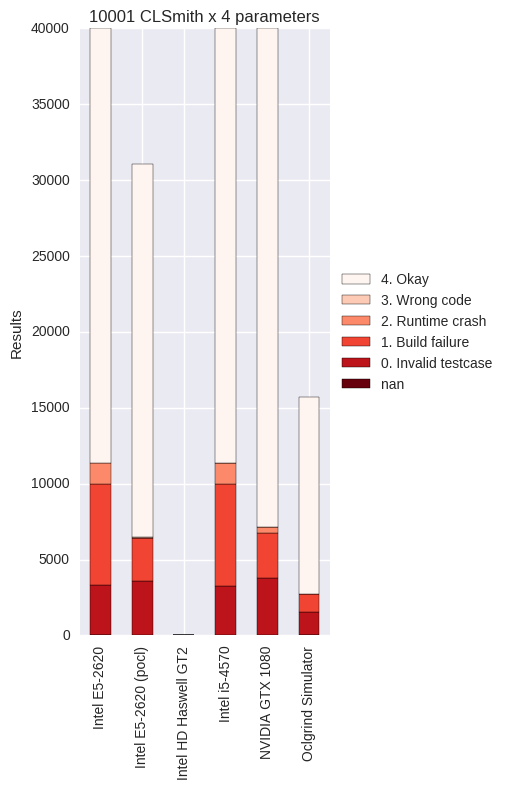

In [14]:
plot_outcomes(CLSmithResult, "CLSmith", dictname=classifications, key='Classification')

### CLSmith w. cldrive

In [15]:
outcomes["CLSmith w. cldrive"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,32899,82.239276
1,NVIDIA GTX 1080,Preprocessing Failed,5311,13.276172
2,NVIDIA GTX 1080,z_Okay,1655,4.137086
3,NVIDIA GTX 1080,No OpenCL kernel,64,0.159984
4,NVIDIA GTX 1080,cldrive Error,56,0.139986
5,NVIDIA GTX 1080,Timeout,12,0.029997
6,NVIDIA GTX 1080,clWaitForEvents(),3,0.007499
7,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.007499
8,NVIDIA GTX 1080,Segmentation Fault,1,0.002500
9,Intel E5-2620,Unsupported Program,37940,94.840516


In [16]:
summarize('CLSmith w. cldrive')

Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 411 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   fa192fb..b4a2163  master -> master


,Platform,Device,Driver,Invalid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,38094,6,92,14,1798
2,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,40004,0,0,0,0
3,NVIDIA CUDA,NVIDIA GTX 1080,375.39,38342,1,6,14,1641
4,Oclgrind,Oclgrind Simulator,16.10,26091,0,0,0,31


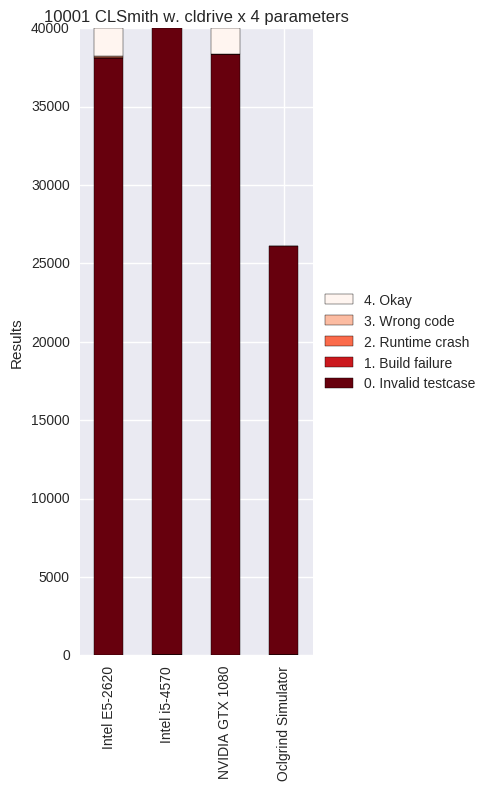

In [17]:
plot_outcomes(cldriveCLSmithResult, "CLSmith w. cldrive", dictname=classifications, key='Classification')

### GitHub

In [18]:
outcomes["GitHub"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,Unsupported Program,17594,37.081375
1,NVIDIA GTX 1080,z_Okay,10019,21.116193
2,NVIDIA GTX 1080,cldrive Error,6816,14.365503
3,NVIDIA GTX 1080,Multiple OpenCL kernels,5330,11.233587
4,NVIDIA GTX 1080,No OpenCL kernel,5018,10.576011
5,NVIDIA GTX 1080,clWaitForEvents(),1502,3.165637
6,NVIDIA GTX 1080,Preprocessing Failed,726,1.530128
7,NVIDIA GTX 1080,INVALID_WORK_GROUP_SIZE,369,0.777710
8,NVIDIA GTX 1080,Timeout,68,0.143318
9,NVIDIA GTX 1080,CL_OUT_OF_HOST_MEMORY,3,0.006323


In [19]:
summarize('GitHub')

Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 452 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   b4a2163..1e45b51  master -> master


,Platform,Device,Driver,Invalid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,27352,1401,32,1041,7126
2,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,2610,48,2,50,989
3,NVIDIA CUDA,NVIDIA GTX 1080,375.39,35921,2,1505,914,9105
4,Oclgrind,Oclgrind Simulator,16.10,216,0,0,0,0


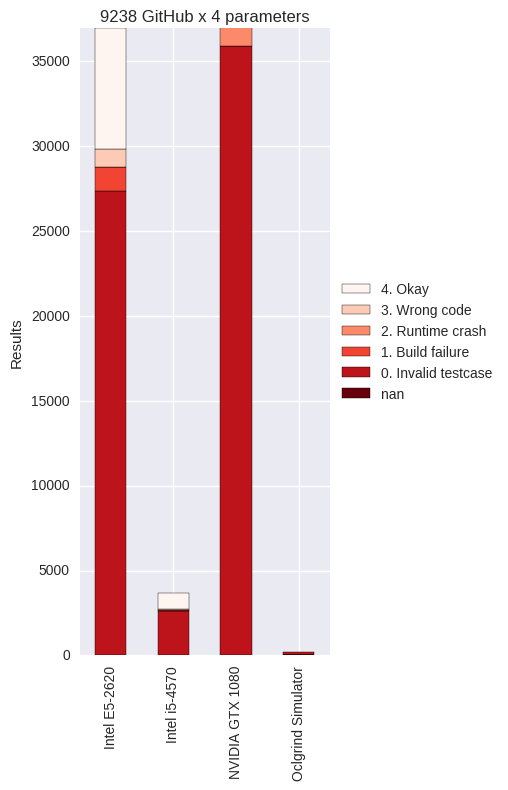

In [20]:
plot_outcomes(GitHubResult, "GitHub", dictname=classifications, key='Classification')

### CLgen

In [21]:
outcomes["CLgen"]

,Device,Outcome,Count,% of Total Results
0,NVIDIA GTX 1080,z_Okay,3994,99.85
1,NVIDIA GTX 1080,clWaitForEvents(),6,0.15
2,Intel E5-2620,z_Okay,3984,99.60
3,Intel E5-2620,Segmentation Fault,16,0.40
4,Intel i5-4570,z_Okay,3918,97.95
5,Intel i5-4570,Segmentation Fault,82,2.05
6,Oclgrind Simulator,z_Okay,3998,99.95
7,Oclgrind Simulator,cldrive Error,2,0.05


In [22]:
summarize('CLgen')

Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 439 bytes | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3)
remote: Updating references: 100% (1/1)
To https://git.overleaf.com/8608915dsywxshwwjmw
   1e45b51..83e4de0  master -> master


,Platform,Device,Driver,Invalid Testcases,Build Failures,Runtime Crashes,Incorrect Outputs,Okay
1,Intel(R) OpenCL,Intel E5-2620,1.2.0.25,0,16,0,647,3337
2,Intel(R) OpenCL,Intel i5-4570,1.2.0.25,0,82,0,625,3293
3,NVIDIA CUDA,NVIDIA GTX 1080,375.39,0,0,6,839,3155
4,Oclgrind,Oclgrind Simulator,16.10,2,0,0,688,3310


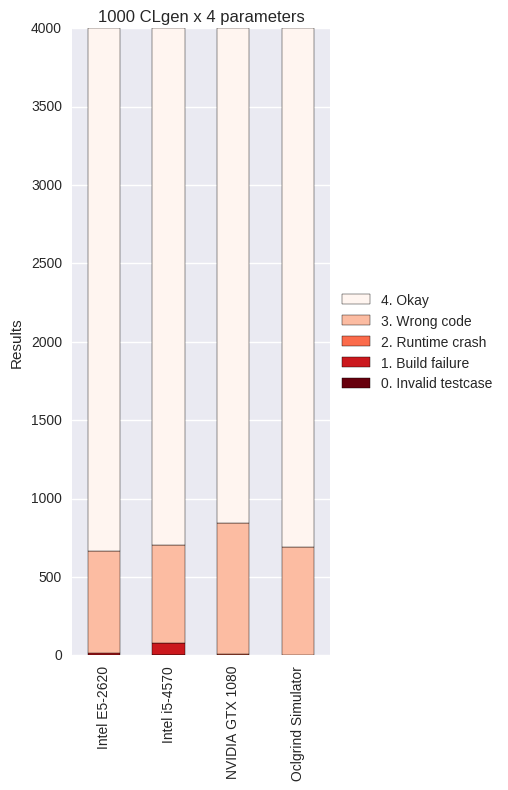

In [23]:
plot_outcomes(CLgenResult, "CLgen", dictname=classifications, key='Classification')

In [24]:
# TODO: GpuVERIFY

# from clgen import preprocess as clgen

# try:
#     clgen.gpuverify("__kernel void A() {}", ["--local_size=64", "--num_groups=128"])
#     gpuverified = True
# except clgen.GPUVerifyException:
#     gpuverified = False
    
# print(gpuverified)